In [1]:
from matplotlib import pyplot as plt

import sys
import pandas as pd
import glob

sys.path.insert(1, '../src/codebase/')

from data_utils import *

%matplotlib inline

# in the notebooks directory
cd ..

# Data directory structure
We have pulled the data that we need, but the structure of the data will be difficult to deal with when we are training and testing. Create a .csv with the file paths to the images and the subdirectories

In [2]:
# one csv for each of the main datasets
mass_buildings = glob.glob('/Users/jwen/Projects/road_building_extraction/data/mass_buildings/**/*.tiff', recursive=True)
mass_roads = glob.glob('/Users/jwen/Projects/road_building_extraction/data/mass_roads/**/*.tiff', recursive=True)

mass_buildings_df = pd.DataFrame(mass_buildings)
mass_roads_df = pd.DataFrame(mass_roads)

mass_buildings_df.rename(columns={0:'file_path'}, inplace=True)
mass_roads_df.rename(columns={0:'file_path'}, inplace=True)

In [34]:
# create new column with the split 
mass_buildings_df['sat_img_path'] = mass_buildings_df['file_path'].apply(lambda x: x.split('/')[-1])
mass_buildings_df['map_img_path'] = mass_buildings_df['file_path'].apply(lambda x: x.split('/')[-1][:-1])
mass_buildings_df['sat_map'] = mass_buildings_df['file_path'].apply(lambda x: x.split('/')[-2])
mass_buildings_df['train_valid_test'] = mass_buildings_df['file_path'].apply(lambda x: x.split('/')[-3])

mass_roads_df['sat_img_path'] = mass_roads_df['file_path'].apply(lambda x: x.split('/')[-1])
mass_roads_df['map_img_path'] = mass_roads_df['file_path'].apply(lambda x: x.split('/')[-1][:-1])
mass_roads_df['sat_map'] = mass_roads_df['file_path'].apply(lambda x: x.split('/')[-2])
mass_roads_df['train_valid_test'] = mass_roads_df['file_path'].apply(lambda x: x.split('/')[-3])

In [35]:
# mass_buildings_df.to_csv('/Users/jwen/Projects/road_building_extraction/data/mass_buildings/mass_buildings.csv', index=False)
# mass_roads_df.to_csv('/Users/jwen/Projects/road_building_extraction/data/mass_roads/mass_roads.csv', index=False)

In [32]:
len(mass_roads_df)

1171

In [33]:
mass_roads_df.head()

,file_path,sat_img_path,map_img_path,train_valid_test
0,/Users/jwen/Projects/road_building_extraction/...,25229230_15.tiff,25229230_15.tif,valid
1,/Users/jwen/Projects/road_building_extraction/...,22528900_15.tiff,22528900_15.tif,valid
2,/Users/jwen/Projects/road_building_extraction/...,24929245_15.tiff,24929245_15.tif,valid
3,/Users/jwen/Projects/road_building_extraction/...,22829035_15.tiff,22829035_15.tif,valid
4,/Users/jwen/Projects/road_building_extraction/...,10978795_15.tiff,10978795_15.tif,valid


# Testing Data Loading

In [3]:
mass_dataset = MassRoadBuildingDataset('/Users/jwen/Projects/road_building_extraction/data/mass_roads/mass_roads.csv','mass_roads','train',
                                       transform=transforms.Compose([RescaleTarget((1000,1400)), RandomCropTarget(768), ToTensorTarget()]))

# RandomRotationTarget(45,resize=True), NormalizeTarget(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

In [4]:
dataloader = DataLoader(mass_dataset, batch_size=6, num_workers=4)

In [7]:
blah = next(iter(dataloader))

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


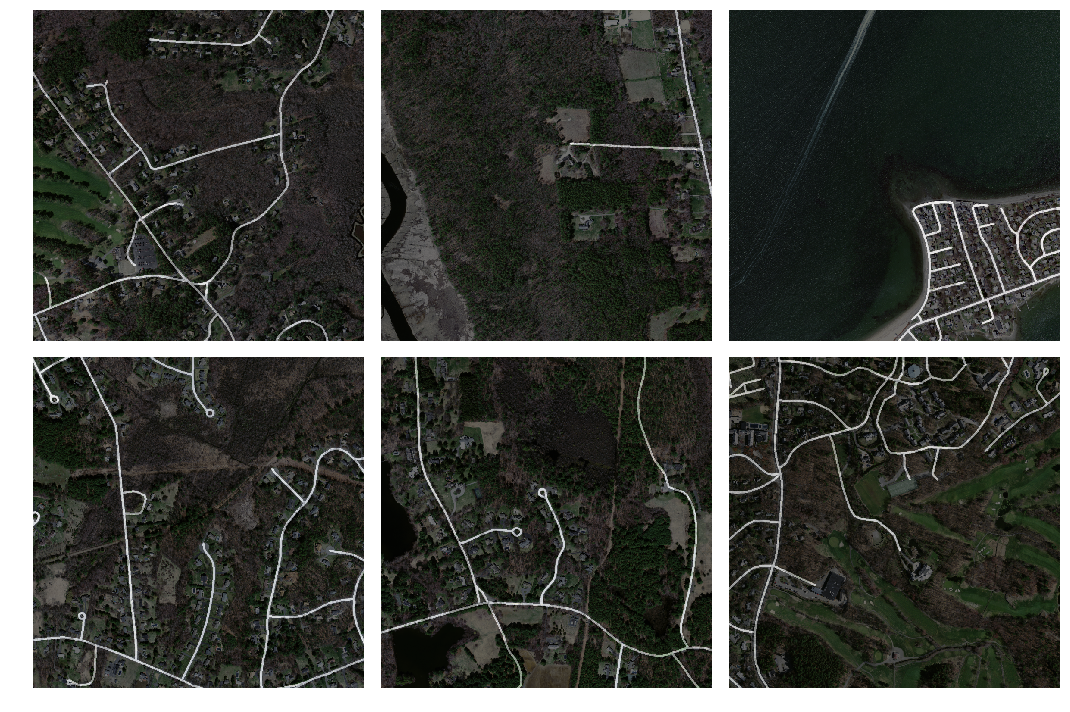

In [8]:
show_map_batch(blah)